<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
    
<h1 style="padding: 10px;color:white; display:fill;background-color:#303090; border-radius:5px; font-size:190%"><b> Table of contents </b></h1>
    
* [**Imports**](#1)
* [**Pre-Processing Dataset**](#2)
* [**EDA**](#3)
* [**Feature selection and Splitting data**](#4)
* [**Modelling Stage**](#5)
    * [**Random Forest**](#5_1)
    * [**LSTM (Keras)**](#5_2)
    * [**Unsupervised Learning AutoEncoder**](#5_3)
    * [**Unsupervised Learning K Means**](#5_4)


<a id='1'></a>
# <p style="padding: 10px;color:white; display:fill;background-color:#303090; border-radius:5px; font-size:80%"> <b>Imports</b>
   

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import ADASYN
import tensorflow as tf


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


<a id='2'></a>
# <p style="padding: 10px;color:white; display:fill;background-color:#303090; border-radius:5px; font-size:80%"> <b>Pre-processing Dataset</b>

In [5]:

def read_parquet_folder(folder_path):
    # List to hold dataframes
    dfs = []

    # Loop through all files in the folder
    for file in os.listdir(folder_path):
        if file.endswith('.parquet'):
            file_path = os.path.join(folder_path, file)

            # Read the parquet file
            df = pd.read_parquet(file_path)

            # Append to the list
            dfs.append(df)

    # Concatenate all dataframes
    combined_df = pd.concat(dfs, ignore_index=True)

    return combined_df

# Specify the path to your folder
folder_path = 'datasets/MachineLearningCVE'

# Read and combine data
df = read_parquet_folder(folder_path)


In [6]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print(categorical_cols)

Index(['Label'], dtype='object')


No categorical columns, all numerical

<a id='3'></a>
# <p style="padding: 10px;color:white; display:fill;background-color:#303090; border-radius:5px; font-size:80%"> <b>Exploritory Data Analysis</b>

In [7]:
df.Label.value_counts()


Label
Benign                        1977318
DoS Hulk                       172846
DDoS                           128014
DoS GoldenEye                   10286
FTP-Patator                      5931
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
PortScan                         1956
Web Attack � Brute Force         1470
Bot                              1437
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

### Combine similar attack types
Increases multi class classification accuracy<br>
Reducing Noise and Overfitting<br>
Enhancing Interpretability<br>
Handling Imbalanced Data<br>

In [8]:
df_experiment = df.copy()

# Replace various Web Attack types with a single label "Web Attack"
df_experiment['Label'] = df_experiment['Label'].str.replace(r'Web Attack.*', 'Web Attack', regex=True)

# Replace FTP-Patator and SSH-Patator with "Brute Force"
df_experiment['Label'] = df_experiment['Label'].replace(r'.*Patator$', 'Brute Force', regex=True)

# Consolidate various DoS attack types into a single "DoS" label
df_experiment['Label'] = df_experiment['Label'].replace(["DoS GoldenEye", "DoS Hulk", "DoS Slowhttptest", "DoS slowloris"], "DoS")

# Ensure that only the following 9 labels exist in the dataset
desired_labels = ["Benign", "DoS", "DDoS", "Brute Force", "PortScan", "Web Attack", "Bot", "Infiltration", "Heartbleed"]

# Replace any label not in desired_labels with 'Other'
df_experiment['Label'] = df_experiment['Label'].apply(lambda x: x if x in desired_labels else 'Other')

# Check the value counts to ensure there are only 9 labels
label_counts = df_experiment['Label'].value_counts()
print(label_counts)

Label
Benign          1977318
DoS              193745
DDoS             128014
Brute Force        9150
Web Attack         2143
PortScan           1956
Bot                1437
Infiltration         36
Heartbleed           11
Name: count, dtype: int64


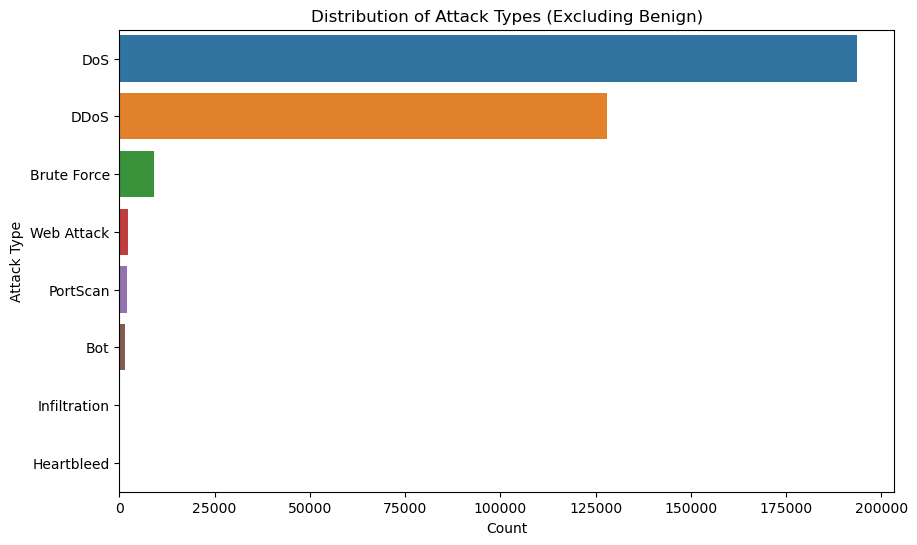

In [7]:
# Assuming 'df_experiment' is already defined and available in this context
# Filtering out the 'Benign' label
df_filtered123 = df_experiment[df_experiment['Label'] != 'Benign']

# Count plot for different labels, excluding 'Benign'
plt.figure(figsize=(10, 6))
sns.countplot(y='Label', data=df_filtered123, order=df_filtered123['Label'].value_counts().index)
plt.title('Distribution of Attack Types (Excluding Benign)')
plt.xlabel('Count')
plt.ylabel('Attack Type')
plt.show()

C:\Users\LEGION\anaconda3\envs\TensorFlowGPU\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


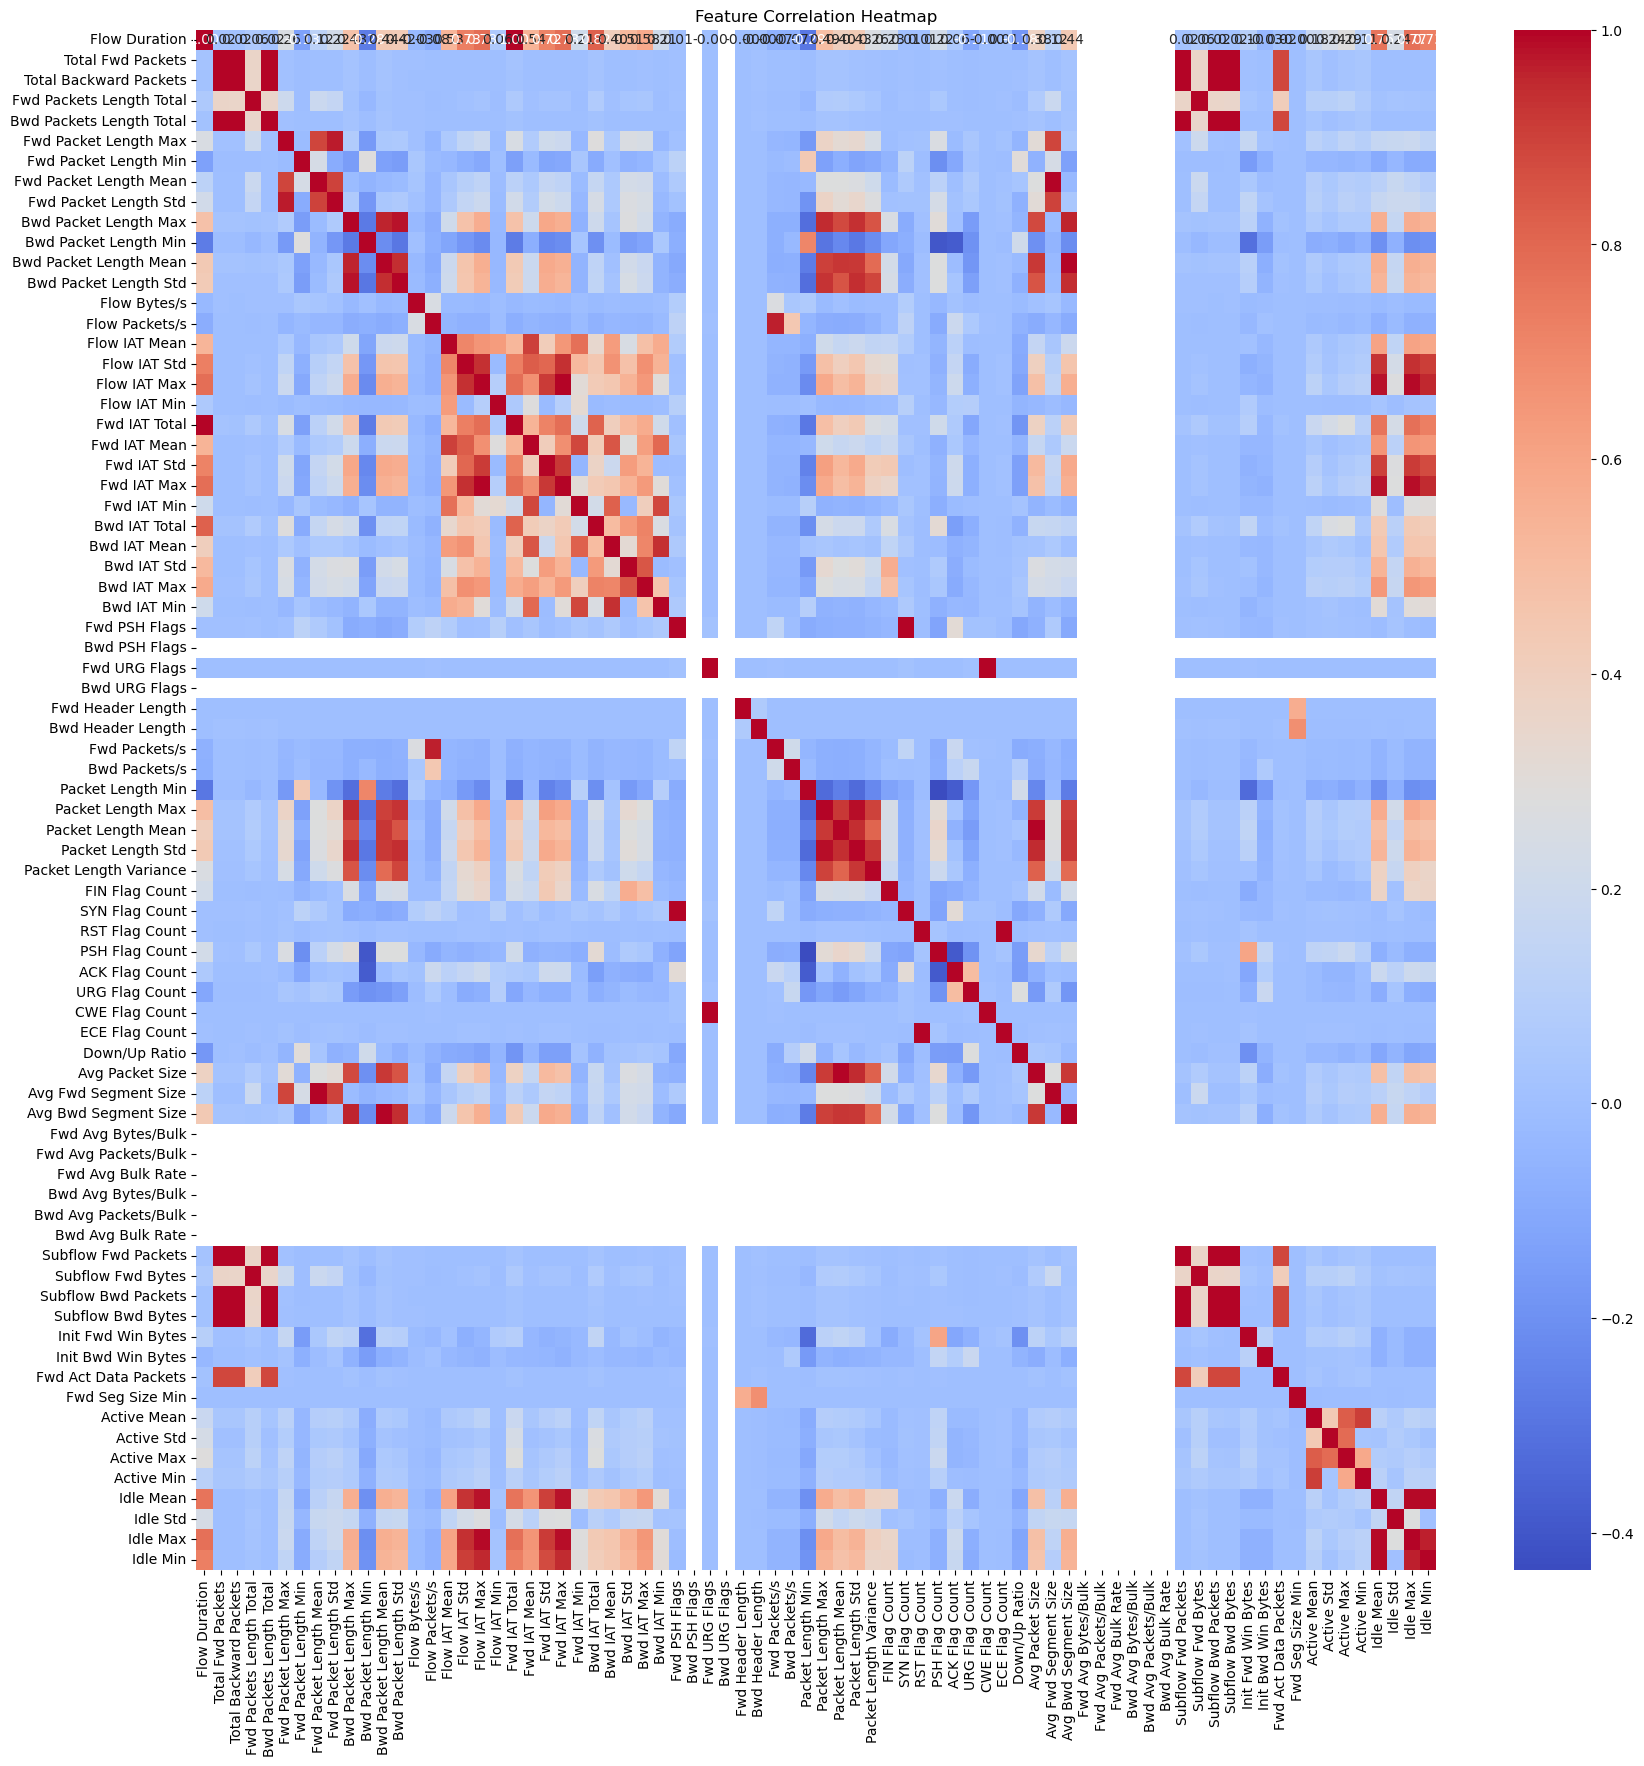

In [8]:
# Compute the correlation matrix
correlation_matrix = df_experiment.drop(columns=['Label']).corr()

# Generate a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

<a id='4'></a>
# <p style="padding: 10px;color:white; display:fill;background-color:#303090; border-radius:5px; font-size:80%"> <b>Feature Extraction and Splitting data</b>

Remove label column to do feature extraction on the data

In [9]:
dfu = df_experiment.drop(columns=['Label'])

### Scaling data first

In [10]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the data and transform it
df_scaled = pd.DataFrame(scaler.fit_transform(dfu), columns=dfu.columns)


In [11]:
df_scaled.head()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Fwd Act Data Packets,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,1.333333e-07,0.000005,0.000000,9.302326e-07,0.000000e+00,0.000242,0.002581,0.00101,0.0,0.000000,...,0.000005,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.016667e-06,0.000000,0.000003,4.651163e-07,9.153974e-09,0.000242,0.002581,0.00101,0.0,0.000307,...,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.416666e-07,0.000000,0.000003,4.651163e-07,9.153974e-09,0.000242,0.002581,0.00101,0.0,0.000307,...,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.916666e-07,0.000000,0.000003,4.651163e-07,9.153974e-09,0.000242,0.002581,0.00101,0.0,0.000307,...,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.333333e-07,0.000005,0.000000,9.302326e-07,0.000000e+00,0.000242,0.002581,0.00101,0.0,0.000000,...,0.000005,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Training and Test split
**Also Add attack category Label for prediction** <br>
**Add training set with synthetic samples using ADASYN for minority samples**

In [1]:
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming df_scaled and df_experiment are already defined

X = df_scaled
y = df_experiment['Label']

# Separate the specified majority classes and the rest
majority_mask = y.isin(['Benign', 'DDoS', 'DoS'])
X_majority = X[majority_mask]
y_majority = y[majority_mask]

X_minority = X[~majority_mask]
y_minority = y[~majority_mask]

# Reduce the majority classes to 30% of their original size
X_majority_reduced, _, y_majority_reduced, _ = train_test_split(X_majority, y_majority, test_size=0.7, random_state=42)
del X_majority, y_majority  # Delete variables no longer needed

# Combine the reduced majority classes with the untouched minority classes
X_combined = pd.concat([X_majority_reduced, X_minority], ignore_index=True)
y_combined = pd.concat([y_majority_reduced, y_minority], ignore_index=True)
del X_majority_reduced, y_majority_reduced, X_minority, y_minority  # Delete intermediate variables

# Now, split the combined dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.3, random_state=42)
del X_combined, y_combined  # Delete the combined datasets after splitting

# Reset the indices of X_train and y_train
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Apply the same logic for separating and recombining for the training set
mask_train = y_train.isin(['DoS', 'Benign'])
X_normal_train = X_train[mask_train]
y_normal_train = y_train[mask_train]

X_other_train = X_train[~mask_train]
y_other_train = y_train[~mask_train]

# Initialize BorderlineSMOTE
bsmote = BorderlineSMOTE(random_state=42, sampling_strategy='auto')

# Apply BorderlineSMOTE to the training data
X_other_resampled, y_other_resampled = bsmote.fit_resample(X_other_train, y_other_train)
del X_other_train, y_other_train  # Delete the other class datasets after resampling

# Combine the datasets
X_train_resampled = pd.concat([X_normal_train, X_other_resampled], ignore_index=True)
y_train_resampled = pd.concat([y_normal_train, y_other_resampled], ignore_index=True)
del X_normal_train, y_normal_train, X_other_resampled, y_other_resampled  # Delete temporary datasets

# X_train_resampled and y_train_resampled are now ready for use

NameError: name 'df_scaled' is not defined

In [13]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))



                     df_scaled:  1.3 GiB
                             X:  1.3 GiB
                            df: 686.7 MiB
                 df_experiment: 685.5 MiB
                           dfu: 547.2 MiB
             X_train_resampled: 374.3 MiB
                       X_train: 285.9 MiB
                             y: 138.3 MiB
                        X_test: 124.2 MiB
                             _: 108.4 MiB


In [14]:
import gc
del df_scaled
del X
del dfu
del df
del df_experiment
del y
gc.collect()


0

In [15]:
# Convert the resampled target array to a pandas Series
y_train_resampled_series = pd.Series(y_train_resampled)

# Get the count of each category
attack_distribution = y_train_resampled_series.value_counts()

# Print the distribution
print(attack_distribution)

Label
Benign          414762
DoS              40914
DDoS             27132
Brute Force      27132
PortScan         27132
Web Attack       27132
Bot              27132
Infiltration     27132
Heartbleed       27132
Name: count, dtype: int64


### PCA Dimension Reduction

In [2]:
from sklearn.decomposition import PCA

# Initialize PCA for the original data
pca = PCA(n_components=40)  

# Fit PCA on the original training data
pca.fit(X_train)

# Transform both original training and test data
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Do the same for the resampled data
# Initialize PCA for the resampled data
pca_resampled = PCA(n_components=40)  

# Fit PCA on the resampled training data
pca_resampled.fit(X_train_resampled)

# Transform both resampled training and original test data using pca_resampled
X_train_pca_resampled = pca_resampled.transform(X_train_resampled)
X_test_pca_resampled = pca_resampled.transform(X_test)

NameError: name 'X_train' is not defined

### Autoencoder Dimension Reduction

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import backend as K

# Assuming X_train and X_test are already defined

# Define the size of the input features and the encoding dimension
input_dim = X_train.shape[1]
encoding_dim = 40  # Dimension of the encoding layer

# Input layer
input_layer = Input(shape=(input_dim,))

# Encoding layer (bottleneck)
encoded = Dense(encoding_dim, activation='relu')(input_layer)

# Decoding layer
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Autoencoder model
autoencoder = Model(input_layer, decoded)

# Encoder model (for later use in transforming data)
encoder = Model(input_layer, encoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
autoencoder.fit(X_train, X_train,
                epochs=25,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))

# Clear the TensorFlow session to free up memory
K.clear_session()


Epoch 1/25
1927/1927 [==============================] - 7s 3ms/step - loss: 0.0095 - val_loss: 4.2219e-04
Epoch 2/25
1927/1927 [==============================] - 5s 3ms/step - loss: 2.8062e-04 - val_loss: 1.9546e-04
Epoch 3/25
1927/1927 [==============================] - 5s 3ms/step - loss: 1.6190e-04 - val_loss: 1.2793e-04
Epoch 4/25
1927/1927 [==============================] - 5s 3ms/step - loss: 1.0524e-04 - val_loss: 8.6113e-05
Epoch 5/25
1927/1927 [==============================] - 5s 2ms/step - loss: 7.5374e-05 - val_loss: 6.5126e-05
Epoch 6/25
1927/1927 [==============================] - 5s 3ms/step - loss: 6.1208e-05 - val_loss: 5.5097e-05
Epoch 7/25
1927/1927 [==============================] - 5s 2ms/step - loss: 5.3835e-05 - val_loss: 4.9778e-05
Epoch 8/25
1927/1927 [==============================] - 5s 3ms/step - loss: 4.9384e-05 - val_loss: 4.6551e-05
Epoch 9/25
1927/1927 [==============================] - 5s 2ms/step - loss: 4.6392e-05 - val_loss: 4.3763e-05
Epoch 10/25
19

In [18]:
# Function for batch processing during encoding
def batch_encode(encoder_model, data, batch_size=256):
    encoded_data = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        encoded_batch = encoder_model.predict(batch)
        encoded_data.append(encoded_batch)
    return np.concatenate(encoded_data, axis=0)

# Transform training and test data using batch processing
X_train_encoded = batch_encode(encoder, X_train)
X_test_encoded = batch_encode(encoder, X_test)


# Now, X_train_encoded and X_test_encoded can be used for training and testing the model respectively

5/5 [==============================] - 0s 1ms/step


### Autoencoder Dimension Reduction with BSMOTE

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import backend as K

# Assuming X_train and X_test are already defined

# Define the size of the input features and the encoding dimension
input_dim = X_train_resampled.shape[1]
encoding_dim = 40  # Dimension of the encoding layer

# Input layer
input_layer = Input(shape=(input_dim,))

# Encoding layer (bottleneck)
encoded = Dense(encoding_dim, activation='relu')(input_layer)

# Decoding layer
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Autoencoder model
autoencoder = Model(input_layer, decoded)

# Encoder model (for later use in transforming data)
encoder = Model(input_layer, encoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
autoencoder.fit(X_train_resampled, X_train_resampled,
                epochs=25,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))

# Clear the TensorFlow session to free up memory
K.clear_session()

Epoch 1/25
2522/2522 [==============================] - 7s 3ms/step - loss: 0.0070 - val_loss: 3.9116e-04
Epoch 2/25
2522/2522 [==============================] - 6s 2ms/step - loss: 2.6654e-04 - val_loss: 1.5843e-04
Epoch 3/25
2522/2522 [==============================] - 6s 2ms/step - loss: 1.2960e-04 - val_loss: 1.0912e-04
Epoch 4/25
2522/2522 [==============================] - 6s 2ms/step - loss: 9.0182e-05 - val_loss: 7.8448e-05
Epoch 5/25
2522/2522 [==============================] - 6s 2ms/step - loss: 6.8450e-05 - val_loss: 6.3687e-05
Epoch 6/25
2522/2522 [==============================] - 6s 2ms/step - loss: 5.7344e-05 - val_loss: 5.6517e-05
Epoch 7/25
2522/2522 [==============================] - 6s 2ms/step - loss: 5.1535e-05 - val_loss: 5.0596e-05
Epoch 8/25
2522/2522 [==============================] - 6s 2ms/step - loss: 4.1969e-05 - val_loss: 4.0215e-05
Epoch 9/25
2522/2522 [==============================] - 6s 3ms/step - loss: 3.7781e-05 - val_loss: 3.8249e-05
Epoch 10/25
25

In [20]:
# Function for batch processing during encoding
def batch_encode(encoder_model, data, batch_size=256):
    encoded_data = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        encoded_batch = encoder_model.predict(batch)
        encoded_data.append(encoded_batch)
    return np.concatenate(encoded_data, axis=0)

# Transform training and test data using batch processing
X_train_encoded_resampled = batch_encode(encoder, X_train_resampled)
X_test_encoded_resampled = batch_encode(encoder, X_test)


# Now, X_train_encoded and X_test_encoded can be used for training and testing the model respectively

5/5 [==============================] - 0s 1ms/step


<a id='5'></a>
# <p style="padding: 10px;color:white; display:fill;background-color:#303090; border-radius:5px; font-size:80%"> <b>Modelling and Evaluation</b>

<a id='5_1'></a>
# <p style="padding: 10px;color:white; display:fill;background-color:#303090; border-radius:5px; font-size:70%"> <b>Random Forest</b>

### No feature extraction, just scaling

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report1 = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report1)
print("\nConfusion Matrix:\n", conf_matrix)

Accuracy: 0.9977240142521187

Classification Report:
               precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    177785
         Bot       0.86      0.78      0.82       423
 Brute Force       1.00      0.98      0.99      2740
        DDoS       1.00      1.00      1.00     11585
         DoS       1.00      0.99      0.99     17545
  Heartbleed       1.00      0.80      0.89         5
Infiltration       1.00      0.71      0.83         7
    PortScan       0.97      0.98      0.97       559
  Web Attack       1.00      0.91      0.95       688

    accuracy                           1.00    211337
   macro avg       0.98      0.91      0.94    211337
weighted avg       1.00      1.00      1.00    211337


Confusion Matrix:
 [[177672     53      2      7     41      0      0     10      0]
 [    95    328      0      0      0      0      0      0      0]
 [    52      0   2687      0      0      0      0      0      1]
 [    11      0      0 

### With PCA Dimension Reduction

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize the Random Forest classifier
rf_classifier1 = RandomForestClassifier(random_state=42)

# Train the classifier
rf_classifier1.fit(X_train_pca, y_train)

# Make predictions on the test set
y_pred = rf_classifier1.predict(X_test_pca)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report1 = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report1)
print("\nConfusion Matrix:\n", conf_matrix)

Accuracy: 0.9981356790339599

Classification Report:
               precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    177785
         Bot       0.85      0.83      0.84       423
 Brute Force       1.00      0.99      1.00      2740
        DDoS       1.00      1.00      1.00     11585
         DoS       1.00      0.99      1.00     17545
  Heartbleed       1.00      0.60      0.75         5
Infiltration       1.00      0.14      0.25         7
    PortScan       0.97      0.96      0.97       559
  Web Attack       0.99      0.97      0.98       688

    accuracy                           1.00    211337
   macro avg       0.98      0.83      0.86    211337
weighted avg       1.00      1.00      1.00    211337


Confusion Matrix:
 [[177644     60      3      6     60      0      0     10      2]
 [    73    350      0      0      0      0      0      0      0]
 [    16      0   2723      0      0      0      0      0      1]
 [    10      1      0 

### With Autoencoder Dimension Reduction

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize the Random Forest classifier
rf_classifier2 = RandomForestClassifier(random_state=42)

# Train the classifier
rf_classifier2.fit(X_train_encoded, y_train)

# Make predictions on the test set
y_pred = rf_classifier2.predict(X_test_encoded)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report1 = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report1)
print("\nConfusion Matrix:\n", conf_matrix)

C:\Users\LEGION\anaconda3\envs\TensorFlowGPU\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LEGION\anaconda3\envs\TensorFlowGPU\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LEGION\anaconda3\envs\TensorFlowGPU\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

Accuracy: 0.9975584019835618

Classification Report:
               precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    177785
         Bot       0.81      0.76      0.78       423
 Brute Force       1.00      0.99      0.99      2740
        DDoS       1.00      1.00      1.00     11585
         DoS       0.99      0.99      0.99     17545
  Heartbleed       1.00      0.60      0.75         5
Infiltration       0.00      0.00      0.00         7
    PortScan       0.96      0.94      0.95       559
  Web Attack       1.00      0.95      0.97       688

    accuracy                           1.00    211337
   macro avg       0.86      0.80      0.83    211337
weighted avg       1.00      1.00      1.00    211337


Confusion Matrix:
 [[177610     76      5      8     72      0      0     14      0]
 [   101    322      0      0      0      0      0      0      0]
 [    24      0   2715      0      0      0      0      0      1]
 [    11      1      0 

### Autoencoder Dimension Reduction with BSMOTE

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize the Random Forest classifier
rf_classifier123 = RandomForestClassifier(random_state=42)

# Train the classifier
rf_classifier123.fit(X_train_encoded_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = rf_classifier123.predict(X_test_encoded_resampled)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report1 = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report1)
print("\nConfusion Matrix:\n", conf_matrix)

Accuracy: 0.9966688275124564

Classification Report:
               precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    177785
         Bot       0.79      0.78      0.78       423
 Brute Force       0.99      0.99      0.99      2740
        DDoS       1.00      1.00      1.00     11585
         DoS       1.00      0.99      0.99     17545
  Heartbleed       1.00      0.60      0.75         5
Infiltration       0.50      0.14      0.22         7
    PortScan       0.75      0.93      0.83       559
  Web Attack       0.92      0.75      0.82       688

    accuracy                           1.00    211337
   macro avg       0.88      0.80      0.82    211337
weighted avg       1.00      1.00      1.00    211337


Confusion Matrix:
 [[177550     86     18      7     68      0      1     13     42]
 [    95    328      0      0      0      0      0      0      0]
 [    28      0   2707      0      0      0      0      1      4]
 [     9      1      0 

### PCA Dimension Reduction with BSMOTE

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize the Random Forest classifier
rf_classifier12 = RandomForestClassifier(random_state=42)

# Train the classifier
rf_classifier12.fit(X_train_pca_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = rf_classifier12.predict(X_test_pca_resampled)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report1 = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report1)
print("\nConfusion Matrix:\n", conf_matrix)

Accuracy: 0.9970615651778912

Classification Report:
               precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    177785
         Bot       0.81      0.81      0.81       423
 Brute Force       1.00      0.99      0.99      2740
        DDoS       1.00      1.00      1.00     11585
         DoS       1.00      0.99      1.00     17545
  Heartbleed       1.00      0.60      0.75         5
Infiltration       1.00      0.29      0.44         7
    PortScan       0.74      0.97      0.84       559
  Web Attack       0.94      0.73      0.82       688

    accuracy                           1.00    211337
   macro avg       0.94      0.82      0.85    211337
weighted avg       1.00      1.00      1.00    211337


Confusion Matrix:
 [[177595     81      7      7     61      0      0     10     24]
 [    81    342      0      0      0      0      0      0      0]
 [    15      0   2720      0      0      0      0      1      4]
 [     9      1      0 

<a id='5_2'></a>
# <p style="padding: 10px;color:white; display:fill;background-color:#303090; border-radius:5px; font-size:70%"> <b>LSTM</b>

## No feature extraction, just scaling

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Assuming your data is already scaled and suitable for LSTM
# Reshape input data to be 3D [samples, timesteps, features]
#let's assume 1 timestep and all features as different time points
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Design the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(1, X_train.shape[1])))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_reshaped, y_train_encoded, epochs=25, batch_size=256, validation_data=(X_test_reshaped, y_test_encoded))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test_encoded)
print("Test Accuracy:", accuracy)

Epoch 1/25
1927/1927 [==============================] - 12s 6ms/step - loss: 0.1556 - accuracy: 0.9574 - val_loss: 0.0719 - val_accuracy: 0.9760
Epoch 2/25
1927/1927 [==============================] - 11s 6ms/step - loss: 0.0754 - accuracy: 0.9757 - val_loss: 0.0589 - val_accuracy: 0.9799
Epoch 3/25
1927/1927 [==============================] - 11s 6ms/step - loss: 0.0647 - accuracy: 0.9781 - val_loss: 0.0514 - val_accuracy: 0.9828
Epoch 4/25
1927/1927 [==============================] - 11s 6ms/step - loss: 0.0583 - accuracy: 0.9798 - val_loss: 0.0636 - val_accuracy: 0.9757
Epoch 5/25
1927/1927 [==============================] - 11s 6ms/step - loss: 0.0542 - accuracy: 0.9811 - val_loss: 0.0450 - val_accuracy: 0.9847
Epoch 6/25
1927/1927 [==============================] - 12s 6ms/step - loss: 0.0513 - accuracy: 0.9822 - val_loss: 0.0445 - val_accuracy: 0.9852
Epoch 7/25
1927/1927 [==============================] - 11s 6ms/step - loss: 0.0496 - accuracy: 0.9826 - val_loss: 0.0420 - val_ac

Text(0.5, 1.0, 'Accuracy over iterations')

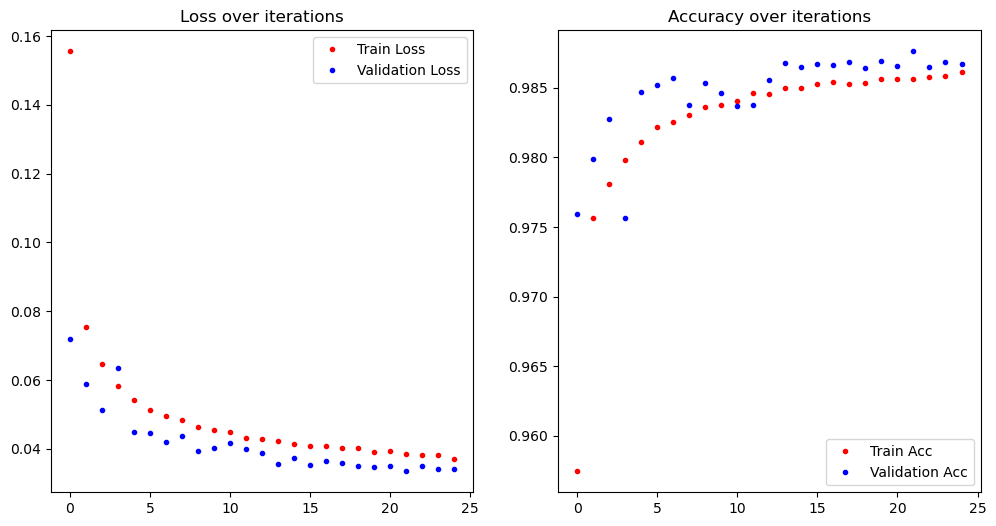

In [24]:
n = len(history.history["loss"])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (history.history["loss"]),'r.', label="Train Loss")
ax.plot(range(n), (history.history["val_loss"]),'b.', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (history.history["accuracy"]),'r.', label="Train Acc")
ax.plot(range(n), (history.history["val_accuracy"]),'b.', label="Validation Acc")
ax.legend(loc='lower right')
ax.set_title('Accuracy over iterations')

## With PCA Dimension Reduction

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Assuming your data is already scaled and suitable for LSTM
# Reshape input data to be 3D [samples, timesteps, features]
#let's assume 1 timestep and all features as different time points
X_train_reshaped = X_train_pca.reshape((X_train_pca.shape[0], 1, X_train_pca.shape[1]))
X_test_reshaped = X_test_pca.reshape((X_test_pca.shape[0], 1, X_test_pca.shape[1]))

# Design the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(1, X_train_pca.shape[1])))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_reshaped, y_train_encoded, epochs=25, batch_size=256, validation_data=(X_test_reshaped, y_test_encoded))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test_encoded)
print("Test Accuracy:", accuracy)

Epoch 1/25
1927/1927 [==============================] - 12s 6ms/step - loss: 0.1451 - accuracy: 0.9639 - val_loss: 0.0705 - val_accuracy: 0.9766
Epoch 2/25
1927/1927 [==============================] - 11s 6ms/step - loss: 0.0678 - accuracy: 0.9775 - val_loss: 0.0596 - val_accuracy: 0.9788
Epoch 3/25
1927/1927 [==============================] - 12s 6ms/step - loss: 0.0611 - accuracy: 0.9790 - val_loss: 0.0523 - val_accuracy: 0.9825
Epoch 4/25
1927/1927 [==============================] - 12s 6ms/step - loss: 0.0571 - accuracy: 0.9801 - val_loss: 0.0509 - val_accuracy: 0.9798
Epoch 5/25
1927/1927 [==============================] - 11s 6ms/step - loss: 0.0541 - accuracy: 0.9809 - val_loss: 0.0488 - val_accuracy: 0.9831
Epoch 6/25
1927/1927 [==============================] - 11s 6ms/step - loss: 0.0516 - accuracy: 0.9818 - val_loss: 0.0546 - val_accuracy: 0.9811
Epoch 7/25
1927/1927 [==============================] - 11s 6ms/step - loss: 0.0506 - accuracy: 0.9821 - val_loss: 0.0462 - val_ac

Text(0.5, 1.0, 'Accuracy over iterations')

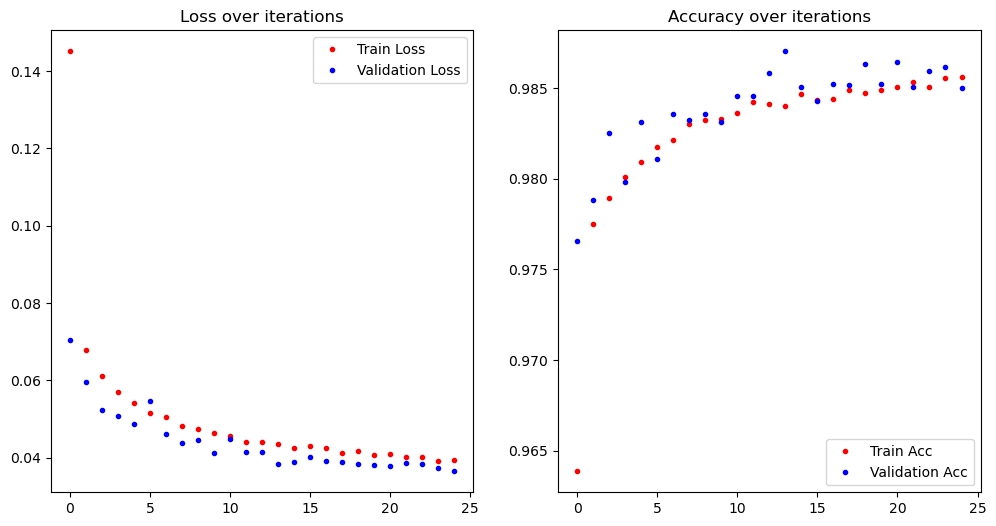

In [27]:
n = len(history.history["loss"])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (history.history["loss"]),'r.', label="Train Loss")
ax.plot(range(n), (history.history["val_loss"]),'b.', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (history.history["accuracy"]),'r.', label="Train Acc")
ax.plot(range(n), (history.history["val_accuracy"]),'b.', label="Validation Acc")
ax.legend(loc='lower right')
ax.set_title('Accuracy over iterations')

## With Autoencoder dimension reduction

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Assuming your data is already scaled and suitable for LSTM
# Reshape input data to be 3D [samples, timesteps, features]
#let's assume 1 timestep and all features as different time points
X_train_reshaped = X_train_encoded.reshape((X_train_encoded.shape[0], 1, X_train_encoded.shape[1]))
X_test_reshaped = X_test_encoded.reshape((X_test_encoded.shape[0], 1, X_test_encoded.shape[1]))

# Design the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(1, X_train_encoded.shape[1])))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_reshaped, y_train_encoded, epochs=25, batch_size=256, validation_data=(X_test_reshaped, y_test_encoded))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test_encoded)
print("Test Accuracy:", accuracy)

Epoch 1/25
1927/1927 [==============================] - 13s 6ms/step - loss: 0.1489 - accuracy: 0.9568 - val_loss: 0.0850 - val_accuracy: 0.9720
Epoch 2/25
1927/1927 [==============================] - 12s 6ms/step - loss: 0.0899 - accuracy: 0.9704 - val_loss: 0.0760 - val_accuracy: 0.9741
Epoch 3/25
1927/1927 [==============================] - 11s 6ms/step - loss: 0.0819 - accuracy: 0.9723 - val_loss: 0.0760 - val_accuracy: 0.9742
Epoch 4/25
1927/1927 [==============================] - 11s 6ms/step - loss: 0.0764 - accuracy: 0.9741 - val_loss: 0.0663 - val_accuracy: 0.9773
Epoch 5/25
1927/1927 [==============================] - 11s 6ms/step - loss: 0.0738 - accuracy: 0.9748 - val_loss: 0.0645 - val_accuracy: 0.9785
Epoch 6/25
1927/1927 [==============================] - 11s 6ms/step - loss: 0.0714 - accuracy: 0.9753 - val_loss: 0.0621 - val_accuracy: 0.9788
Epoch 7/25
1927/1927 [==============================] - 11s 6ms/step - loss: 0.0692 - accuracy: 0.9763 - val_loss: 0.0600 - val_ac

Text(0.5, 1.0, 'Accuracy over iterations')

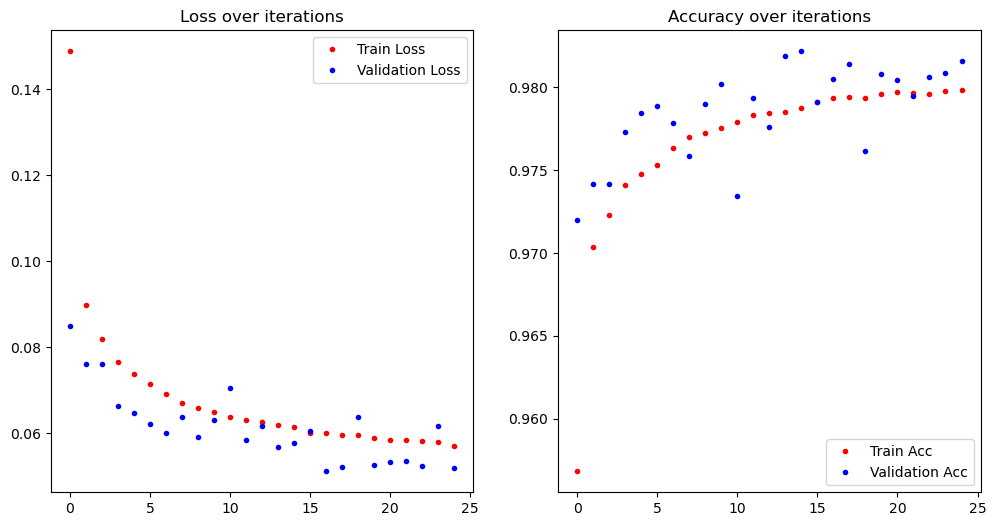

In [29]:
n = len(history.history["loss"])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (history.history["loss"]),'r.', label="Train Loss")
ax.plot(range(n), (history.history["val_loss"]),'b.', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (history.history["accuracy"]),'r.', label="Train Acc")
ax.plot(range(n), (history.history["val_accuracy"]),'b.', label="Validation Acc")
ax.legend(loc='lower right')
ax.set_title('Accuracy over iterations')

<a id='5_3'></a>
# <p style="padding: 10px;color:white; display:fill;background-color:#303090; border-radius:5px; font-size:70%"> <b>Unsupervised Autoencoder</b>

### Splitting Data for Autoencoder

In [17]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming df_scaled and df_experiment['Label'] are already defined

# Separate normal and anomalous data
normal_data = df_scaled[df_experiment['Label'] == 'Benign']
anomalous_data = df_scaled[df_experiment['Label'] != 'Benign']

# Reduce the size of normal down to 30% and have option to reduce anomalous (currently not downsizing)
normal_data_reduced = normal_data.sample(frac=0.3, random_state=42)
anomalous_data_reduced = anomalous_data.sample(frac=1, random_state=42)

# Delete the original datasets to free up memory
del normal_data, anomalous_data

# Split the normal data into training and test sets
X_train_normal, X_test_normal = train_test_split(normal_data_reduced, test_size=0.3, random_state=42)

# Split the anomalous data into test set (no training data needed for anomalies)
_, X_test_anomalies = train_test_split(anomalous_data_reduced, test_size=0.3, random_state=42)

# Delete the reduced datasets as they are no longer needed
del normal_data_reduced, anomalous_data_reduced


In [20]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))



                X_train_normal: 243.9 MiB
                             _: 138.4 MiB
                 X_test_normal: 104.5 MiB
              X_test_anomalies: 59.3 MiB
                            _9:  3.1 KiB
                            __:  1.8 KiB
                            _5:  1.8 KiB
                  MinMaxScaler:  1.4 KiB
                          _i13:  1.1 KiB
                          _i15:  1.1 KiB


In [19]:
import gc
del df_scaled
del dfu
del df
del df_experiment
gc.collect()

0

### Model

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Define the autoencoder architecture
input_dim = X_train_normal.shape[1]
encoding_dim = 32  # This is a hyperparameter and can be tuned

# Encoder
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)

# Decoder
decoder = Dense(input_dim, activation='sigmoid')(encoder)

# Autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile the autoencoder
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the autoencoder
autoencoder.fit(X_train_normal, X_train_normal,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_normal, X_test_normal))

Epoch 1/50
1623/1623 [==============================] - 5s 2ms/step - loss: 0.0127 - val_loss: 7.7903e-04
Epoch 2/50
1623/1623 [==============================] - 4s 2ms/step - loss: 4.9456e-04 - val_loss: 2.9669e-04
Epoch 3/50
1623/1623 [==============================] - 4s 2ms/step - loss: 2.3920e-04 - val_loss: 1.9663e-04
Epoch 4/50
1623/1623 [==============================] - 4s 2ms/step - loss: 1.5516e-04 - val_loss: 1.3246e-04
Epoch 5/50
1623/1623 [==============================] - 4s 2ms/step - loss: 1.1347e-04 - val_loss: 1.0115e-04
Epoch 6/50
1623/1623 [==============================] - 4s 2ms/step - loss: 9.1101e-05 - val_loss: 8.3220e-05
Epoch 7/50
1623/1623 [==============================] - 4s 2ms/step - loss: 7.6431e-05 - val_loss: 7.0821e-05
Epoch 8/50
1623/1623 [==============================] - 4s 2ms/step - loss: 6.6430e-05 - val_loss: 6.4233e-05
Epoch 9/50
1623/1623 [==============================] - 4s 2ms/step - loss: 6.0078e-05 - val_loss: 5.7637e-05
Epoch 10/50
16

In [22]:
# Function to calculate reconstruction error
def calculate_reconstruction_error(data):
    predictions = autoencoder.predict(data)
    reconstruction_error = np.mean(np.power(data - predictions, 2), axis=1)
    return reconstruction_error

# Calculate reconstruction error for both normal and anomalous test data
error_normal = calculate_reconstruction_error(X_test_normal)
error_anomalies = calculate_reconstruction_error(X_test_anomalies)

3155/3155 [==============================] - 3s 853us/step


In [35]:
# Determine a threshold for anomaly detection
threshold = np.percentile(error_normal, 98.3)  # Optimal is between 98 and 99

# Classify as anomalies or normal based on the threshold
is_anomaly_normal = error_normal > threshold
is_anomaly_anomalous = error_anomalies > threshold

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report

# Assuming true labels are 0 for normal and 1 for anomalies
y_true = np.concatenate([np.zeros(len(X_test_normal)), np.ones(len(X_test_anomalies))])
y_pred = np.concatenate([is_anomaly_normal.astype(int), is_anomaly_anomalous.astype(int)])

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_true, y_pred))

Accuracy: 0.8853847339794269
              precision    recall  f1-score   support

         0.0       0.86      0.98      0.92    177959
         1.0       0.96      0.71      0.82    100948

    accuracy                           0.89    278907
   macro avg       0.91      0.85      0.87    278907
weighted avg       0.89      0.89      0.88    278907



<a id='5_4'></a>
# <p style="padding: 10px;color:white; display:fill;background-color:#303090; border-radius:5px; font-size:70%"> <b>Unsupervised Learning K Means</b>

In [28]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
from sklearn.metrics import classification_report, confusion_matrix

# Assuming df_scaled is your scaled feature set

# Initialize K-Means
kmeans = KMeans(n_clusters=2, random_state=42)  # Adjust n_clusters based on domain knowledge or experimentation
kmeans.fit(df_scaled)

# Calculate distances to the nearest cluster center
distances = np.min(cdist(df_scaled, kmeans.cluster_centers_, 'euclidean'), axis=1)

# Determine the threshold for anomalies
threshold = np.percentile(distances, 78)  # This can be tuned

# Detect anomalies (points with distances above the threshold)
anomalies_kmeans = distances > threshold

# True labels (0 for 'Benign' and 1 for others)
true_labels = df_experiment['Label'].apply(lambda x: 0 if x == 'Benign' else 1).values

# Calculate accuracy
accuracy_kmeans = accuracy_score(true_labels, anomalies_kmeans)
print("Accuracy:", accuracy_kmeans)

# Print the classification report for precision, recall, and F1-score
print(classification_report(true_labels, anomalies_kmeans))

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(true_labels, anomalies_kmeans))

C:\Users\LEGION\anaconda3\envs\TensorFlowGPU\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Accuracy: 0.7915135642079514
              precision    recall  f1-score   support

           0       0.91      0.83      0.87   1977318
           1       0.36      0.54      0.43    336492

    accuracy                           0.79   2313810
   macro avg       0.64      0.69      0.65   2313810
weighted avg       0.83      0.79      0.81   2313810

Confusion Matrix:
[[1649846  327472]
 [ 154926  181566]]
